# Baseline Autoencoder Anomaly Detection Demo

##1. Import the Necessary Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError, Reduction
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import leaky_relu

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from functools import partial
from re import X

In [2]:
repo_url = "https://github.com/dzakialaqsha/autoencoder-benford-analysis.git"
!git clone {repo_url}

Cloning into 'autoencoder-benford-analysis'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 114 (delta 48), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 14.28 MiB | 3.77 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [3]:
#import utility functions from repo
%cd "/content/autoencoder-benford-analysis/utils"
import data_preprocessing
import model_building

/content/autoencoder-benford-analysis/utils


In [4]:
fraud_data = pd.read_csv('/content/autoencoder-benford-analysis/data/fraud_dataset_v1.csv')
fraud_data.head(20)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label
0,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


In [5]:
sampled_fraud_data = data_preprocessing.benford_distribution_preserving_sampling(fraud_data, 'HKONT', 'DMBTR', 100000)
sampled_fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100042 entries, 0 to 100041
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   WAERS   100042 non-null  object 
 1   BUKRS   100042 non-null  object 
 2   KTOSL   100042 non-null  object 
 3   BELNR   100042 non-null  object 
 4   BSCHL   100042 non-null  object 
 5   HKONT   100042 non-null  object 
 6   DMBTR   100042 non-null  float64
 7   WRBTR   100042 non-null  float64
 8   label   100042 non-null  object 
dtypes: float64(2), object(7)
memory usage: 6.9+ MB


In [6]:
sampled_fraud_data = pd.concat([sampled_fraud_data, fraud_data[fraud_data.label == "global"], fraud_data[fraud_data.label == "local"]], axis='rows')
old_data = sampled_fraud_data.copy()
sampled_fraud_data.value_counts('label')

,count
label,
regular,99968
global,140
local,34


In [7]:
sampled_fraud_data = sampled_fraud_data.drop(['label'], axis='columns')
np_sampled_fraud_data = data_preprocessing.data_preprocessing(sampled_fraud_data, ['WAERS', 'BUKRS', 'KTOSL', 'BELNR', 'BSCHL', 'HKONT'], ['DMBTR', 'WRBTR'])

In [8]:
np_sampled_fraud_data

array([[9.99999672e-01, 9.99999815e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.18018667e-02, 1.18066500e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.98130551e-03, 1.70193656e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.85066169e-03, 9.13532957e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.85084708e-03, 9.13681232e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.85056499e-03, 9.13810929e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## 2. Build the Model

In [9]:
autoencoder_model = model_building.build_autoencoder(input_dim=np_sampled_fraud_data.shape[1], latent_dim=2)
autoencoder_model.summary()

Model: "Functional_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 618)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       158,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_5 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_6 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_7 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent_Space (Dense)            │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_5 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_6 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_7 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reconstruction_Output (Dense)   │ (None, 618)            │       158,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,428 (1.55 MB)

 Trainable params: 405,428 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0141
Epoch 2/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0044
Epoch 3/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0034
Epoch 4/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0036
Epoch 5/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0037
Epoch 6/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0037
Epoch 7/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0036
Epoch 8/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0037
Epoch 9/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0038
Epoch 10/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0040
Epoch 11/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0040
Epoch 12/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0040
Epoch 13/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0040
Epoch 14/15
3130/3130 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0041
Epoch 15/15
313

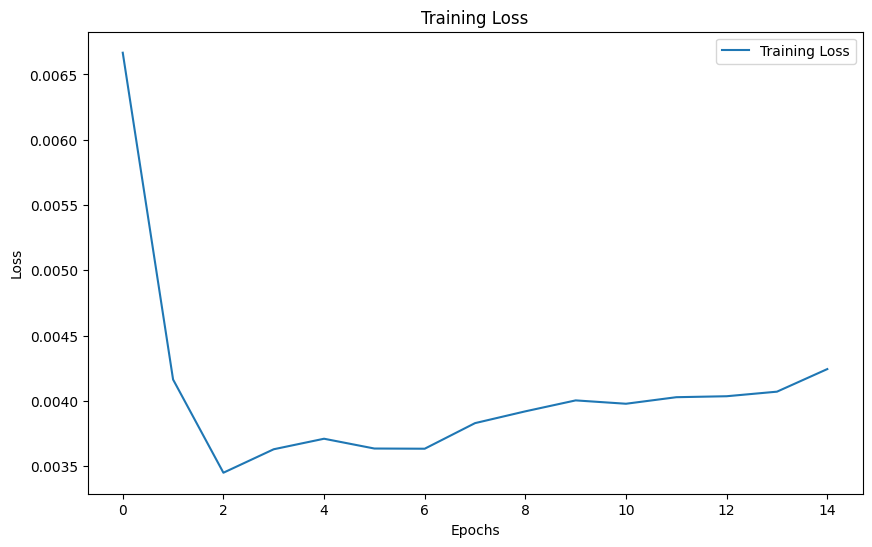

In [10]:
history, reconstructions, individual_mse, fig = model_building.train_autoencoder(autoencoder_model, np_sampled_fraud_data, epochs=15, batch_size=128, learning_rate=0.001)

## 3. Model Prediction

In [11]:
old_data['label'] = old_data['label'].isin(['global','local']).astype(int)

In [12]:
old_data.head(20)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0
5,C1,C18,C5,C59,A1,B1,1.253433e+06,2.883750e+05,0
6,C1,C19,C1,C11,A1,B1,1.398734e+05,0.000000e+00,0
7,C2,C20,C1,C19,A1,B1,1.292003e+06,5.962400e+04,0
8,C1,C17,C1,C16,A1,B1,1.633361e+05,2.108800e+04,0
9,C1,C15,C9,C99,A1,B1,1.090806e+05,0.000000e+00,0


$$
\text{desired percentile} = \frac{\text{number of observations} - \text{desired number of observations to be flagged}}{\text{number of observations}} \cdot 100
$$

In [18]:
desired_percentile = float(((old_data.shape[0] - 150) / old_data.shape[0]) * 100)
percentile = float(np.percentile(individual_mse, desired_percentile))

percentile = float(np.percentile(individual_mse, desired_percentile))
prediction_data = model_building.heaviside_step_function(old_data, individual_mse, percentile)
prediction_data.head(15)

,WAERS,BUKRS,KTOSL,BELNR,BSCHL,HKONT,DMBTR,WRBTR,label,reconstruction_error,predicted_label
0,J73,K76,Q44,K32,H00,A42,9.244551e+07,5.958505e+07,1,0.016181,1
1,C9,C90,C1,C18,A2,B1,1.091040e+06,7.035000e+03,0,0.004855,0
2,C2,C28,C1,C10,A1,B1,1.831726e+05,1.014100e+04,0,0.003236,0
3,C1,C19,C5,C58,A1,B1,1.154395e+06,0.000000e+00,0,0.004855,0
4,C7,C70,C1,C15,A3,B1,1.537143e+06,0.000000e+00,0,0.004855,0
5,C1,C18,C5,C59,A1,B1,1.253433e+06,2.883750e+05,0,0.004855,0
6,C1,C19,C1,C11,A1,B1,1.398734e+05,0.000000e+00,0,0.003236,0
7,C2,C20,C1,C19,A1,B1,1.292003e+06,5.962400e+04,0,0.001618,0
8,C1,C17,C1,C16,A1,B1,1.633361e+05,2.108800e+04,0,0.003236,0
9,C1,C15,C9,C99,A1,B1,1.090806e+05,0.000000e+00,0,0.004854,0


In [19]:
prediction_data.value_counts('label')

,count
label,
0,99968
1,174


In [20]:
prediction_data.value_counts('predicted_label')

,count
predicted_label,
0,99992
1,150


## 4. Model Prediction Evaluation

In [21]:
accuracy, precision, recall, f1, confusion_mat = model_building.evaluate_prediction(prediction_data, 'label', 'predicted_label')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9995606239140421
Precision: 0.9333333333333333
Recall: 0.8045977011494253
F1 Score: 0.8641975308641975
